# Inspiration

##### Renewable energy remains one of the most important topics for a sustainable future. Wind, being a perennial source of power, could be utilized to satisfy our power requirements. With the rise of wind farms, wind power forecasting would prove to be quite useful.

### Context:
##### The aim of this project is to predict the wind power that could be generated from the windmill for the next 15 days. A long term wind forecasting technique is thus required.

### Content:
##### Data has been recorded from January 2018 till March 2020. Readings have been recorded at a 10-minute interval.

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Turbine_Data.csv')

In [4]:
df.head()

Unnamed: 0  ActivePower  AmbientTemperatue  \
0  2017-12-31 00:00:00+00:00          NaN                NaN   
1  2017-12-31 00:10:00+00:00          NaN                NaN   
2  2017-12-31 00:20:00+00:00          NaN                NaN   
3  2017-12-31 00:30:00+00:00          NaN                NaN   
4  2017-12-31 00:40:00+00:00          NaN                NaN   

   BearingShaftTemperature  Blade1PitchAngle  Blade2PitchAngle  \
0                      NaN               NaN               NaN   
1                      NaN               NaN               NaN   
2                      NaN               NaN               NaN   
3                      NaN               NaN               NaN   
4                      NaN               NaN               NaN   

   Blade3PitchAngle  ControlBoxTemperature  GearboxBearingTemperature  \
0               NaN                    NaN                        NaN   
1               NaN                    NaN                        NaN   
2               NaN                    NaN                        NaN   
3               NaN                    NaN                        NaN   
4               NaN                    NaN                        NaN   

   GearboxOilTemperature  GeneratorRPM  GeneratorWinding1Temperature  \
0                    NaN           NaN                           NaN   
1                    NaN           NaN                           NaN   
2                    NaN           NaN                           NaN   
3                    NaN           NaN                           NaN   
4                    NaN           NaN                           NaN   

   GeneratorWinding2Temperature  HubTemperature  MainBoxTemperature  \
0                           NaN             NaN                 NaN   
1                           NaN             NaN                 NaN   
2                           NaN             NaN                 NaN   
3                           NaN             NaN                 NaN   
4                           NaN             NaN                 NaN   

   NacellePosition  ReactivePower  RotorRPM  TurbineStatus  WTG  \
0              NaN            NaN       NaN            NaN  G01   
1              NaN            NaN       NaN            NaN  G01   
2              NaN            NaN       NaN            NaN  G01   
3              NaN            NaN       NaN            NaN  G01   
4              NaN            NaN       NaN            NaN  G01   

   WindDirection  WindSpeed  
0            NaN        NaN  
1            NaN        NaN  
2            NaN        NaN  
3            NaN        NaN  
4            NaN        NaN

### Data Summary
- Rows: 118224
- Columns: 22
- Time Range: Starting from 2017-12-31 00:00:00+00:00
- Target Variable: ActivePower

### Column Description
- Unnamed: 0: Timestamp of the reading
- ActivePower: Actual Power generated by the turbine (Target Variable)
- AmbientTemperature: Outside Air Temperaature
- BearingShaftTemperature: Temperature of the turbine's shaft bearing
- Blade1PitchAngle - Blade3PitchAngle: Angles of each blade - affect power generation
- ControlBoxTemperature: Internal temperature of the control box
- GearboxBearingTemperature: Temperature of the gearbox bearing
- GearboxOilTemperature: Temperature of oil in the gearbox
- GeneratorRPM: Generator Revolutions Per Minute
- GeneratorWinding1Temperature - GeneratorWinding2Temperature: Temperature in Generator Windings
- HubTemperature: Temperature in rotar hub
- MainBoxTemperature: Another Key internal temperature reading
- NacellePosition: Orientation of the Turbine (Degrees from the turbine)
- ReactivePower: Power that does no useful work (Reactive Component)
- RotarRPM: Rotar Speed
- TurbineStatus: Operating Status
- WTG: Turbine Id - Could be useful if the data includes multiple turbines
- WindDirection: Wind direction coming from
- WindSpeed: Wind Speed - a critical input for forecasting power

In [5]:
# keeping the Unnamed: 0 column as the index column
df = pd.read_csv('Turbine_Data.csv', parse_dates=['Unnamed: 0'], index_col=['Unnamed: 0'])
df.index = pd.to_datetime(df.index)

In [6]:
df

ActivePower  AmbientTemperatue  \
2017-12-31 00:00:00+00:00          NaN                NaN   
2017-12-31 00:10:00+00:00          NaN                NaN   
2017-12-31 00:20:00+00:00          NaN                NaN   
2017-12-31 00:30:00+00:00          NaN                NaN   
2017-12-31 00:40:00+00:00          NaN                NaN   
...                                ...                ...   
2020-03-30 23:10:00+00:00    70.044465          27.523741   
2020-03-30 23:20:00+00:00    40.833474          27.602882   
2020-03-30 23:30:00+00:00    20.777790          27.560925   
2020-03-30 23:40:00+00:00    62.091039          27.810472   
2020-03-30 23:50:00+00:00    68.664425          27.915828   

                           BearingShaftTemperature  Blade1PitchAngle  \
2017-12-31 00:00:00+00:00                      NaN               NaN   
2017-12-31 00:10:00+00:00                      NaN               NaN   
2017-12-31 00:20:00+00:00                      NaN               NaN   
2017-12-31 00:30:00+00:00                      NaN               NaN   
2017-12-31 00:40:00+00:00                      NaN               NaN   
...                                            ...               ...   
2020-03-30 23:10:00+00:00                45.711129          1.515669   
2020-03-30 23:20:00+00:00                45.598573          1.702809   
2020-03-30 23:30:00+00:00                45.462045          1.706214   
2020-03-30 23:40:00+00:00                45.343827          1.575352   
2020-03-30 23:50:00+00:00                45.231610          1.499323   

                           Blade2PitchAngle  Blade3PitchAngle  \
2017-12-31 00:00:00+00:00               NaN               NaN   
2017-12-31 00:10:00+00:00               NaN               NaN   
2017-12-31 00:20:00+00:00               NaN               NaN   
2017-12-31 00:30:00+00:00               NaN               NaN   
2017-12-31 00:40:00+00:00               NaN               NaN   
...                                     ...               ...   
2020-03-30 23:10:00+00:00          1.950088          1.950088   
2020-03-30 23:20:00+00:00          2.136732          2.136732   
2020-03-30 23:30:00+00:00          2.139664          2.139664   
2020-03-30 23:40:00+00:00          2.009781          2.009781   
2020-03-30 23:50:00+00:00          1.933124          1.933124   

                           ControlBoxTemperature  GearboxBearingTemperature  \
2017-12-31 00:00:00+00:00                    NaN                        NaN   
2017-12-31 00:10:00+00:00                    NaN                        NaN   
2017-12-31 00:20:00+00:00                    NaN                        NaN   
2017-12-31 00:30:00+00:00                    NaN                        NaN   
2017-12-31 00:40:00+00:00                    NaN                        NaN   
...                                          ...                        ...   
2020-03-30 23:10:00+00:00                    0.0                  59.821165   
2020-03-30 23:20:00+00:00                    0.0                  59.142038   
2020-03-30 23:30:00+00:00                    0.0                  58.439439   
2020-03-30 23:40:00+00:00                    0.0                  58.205413   
2020-03-30 23:50:00+00:00                    0.0                  58.581716   

                           GearboxOilTemperature  GeneratorRPM  \
2017-12-31 00:00:00+00:00                    NaN           NaN   
2017-12-31 00:10:00+00:00                    NaN           NaN   
2017-12-31 00:20:00+00:00                    NaN           NaN   
2017-12-31 00:30:00+00:00                    NaN           NaN   
2017-12-31 00:40:00+00:00                    NaN           NaN   
...                                          ...           ...   
2020-03-30 23:10:00+00:00              55.193793   1029.870744   
2020-03-30 23:20:00+00:00              54.798545   1030.160478   
2020-03-30 23:30:00+00:00              54.380456   1030.137822   
2020-03-30 23:40:00+00:00              

In [7]:
df.isna().sum()

ActivePower                     23474
AmbientTemperatue               24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
ControlBoxTemperature           56064
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WTG                                 0
WindDirection                   45946
WindSpeed                       23629
dtype: int64

In [8]:
df[df.isna().any(axis=1)]

ActivePower  AmbientTemperatue  \
2017-12-31 00:00:00+00:00          NaN                NaN   
2017-12-31 00:10:00+00:00          NaN                NaN   
2017-12-31 00:20:00+00:00          NaN                NaN   
2017-12-31 00:30:00+00:00          NaN                NaN   
2017-12-31 00:40:00+00:00          NaN                NaN   
...                                ...                ...   
2020-03-28 12:00:00+00:00  1640.370106                NaN   
2020-03-28 12:10:00+00:00  1627.063256                NaN   
2020-03-28 12:20:00+00:00  1509.397416                NaN   
2020-03-28 12:30:00+00:00  1583.260472                NaN   
2020-03-28 12:40:00+00:00  1458.573171                NaN   

                           BearingShaftTemperature  Blade1PitchAngle  \
2017-12-31 00:00:00+00:00                      NaN               NaN   
2017-12-31 00:10:00+00:00                      NaN               NaN   
2017-12-31 00:20:00+00:00                      NaN               NaN   
2017-12-31 00:30:00+00:00                      NaN               NaN   
2017-12-31 00:40:00+00:00                      NaN               NaN   
...                                            ...               ...   
2020-03-28 12:00:00+00:00                      NaN          1.697121   
2020-03-28 12:10:00+00:00                      NaN          1.075318   
2020-03-28 12:20:00+00:00                      NaN          0.773788   
2020-03-28 12:30:00+00:00                      NaN          0.347225   
2020-03-28 12:40:00+00:00                      NaN          0.207726   

                           Blade2PitchAngle  Blade3PitchAngle  \
2017-12-31 00:00:00+00:00               NaN               NaN   
2017-12-31 00:10:00+00:00               NaN               NaN   
2017-12-31 00:20:00+00:00               NaN               NaN   
2017-12-31 00:30:00+00:00               NaN               NaN   
2017-12-31 00:40:00+00:00               NaN               NaN   
...                                     ...               ...   
2020-03-28 12:00:00+00:00          2.779623          2.779623   
2020-03-28 12:10:00+00:00          1.809176          1.809176   
2020-03-28 12:20:00+00:00          1.113867          1.113867   
2020-03-28 12:30:00+00:00          0.530028          0.530028   
2020-03-28 12:40:00+00:00          0.992360          0.992360   

                           ControlBoxTemperature  GearboxBearingTemperature  \
2017-12-31 00:00:00+00:00                    NaN                        NaN   
2017-12-31 00:10:00+00:00                    NaN                        NaN   
2017-12-31 00:20:00+00:00                    NaN                        NaN   
2017-12-31 00:30:00+00:00                    NaN                        NaN   
2017-12-31 00:40:00+00:00                    NaN                        NaN   
...                                          ...                        ...   
2020-03-28 12:00:00+00:00                    NaN                        NaN   
2020-03-28 12:10:00+00:00                    NaN                        NaN   
2020-03-28 12:20:00+00:00                    NaN                        NaN   
2020-03-28 12:30:00+00:00                    NaN                        NaN   
2020-03-28 12:40:00+00:00                    NaN                        NaN   

                           GearboxOilTemperature  GeneratorRPM  \
2017-12-31 00:00:00+00:00                    NaN           NaN   
2017-12-31 00:10:00+00:00                    NaN           NaN   
2017-12-31 00:20:00+00:00                    NaN           NaN   
2017-12-31 00:30:00+00:00                    NaN           NaN   
2017-12-31 00:40:00+00:00                    NaN           NaN   
...                                          ...           ...   
2020-03-28 12:00:00+00:00                    NaN           NaN   
2020-03-28 12:10:00+00:00                    NaN           NaN   
2020-03-28 12:20:00+00:00                    NaN           NaN   
2020-03-28 12:30:00+00:00              

<Axes: >

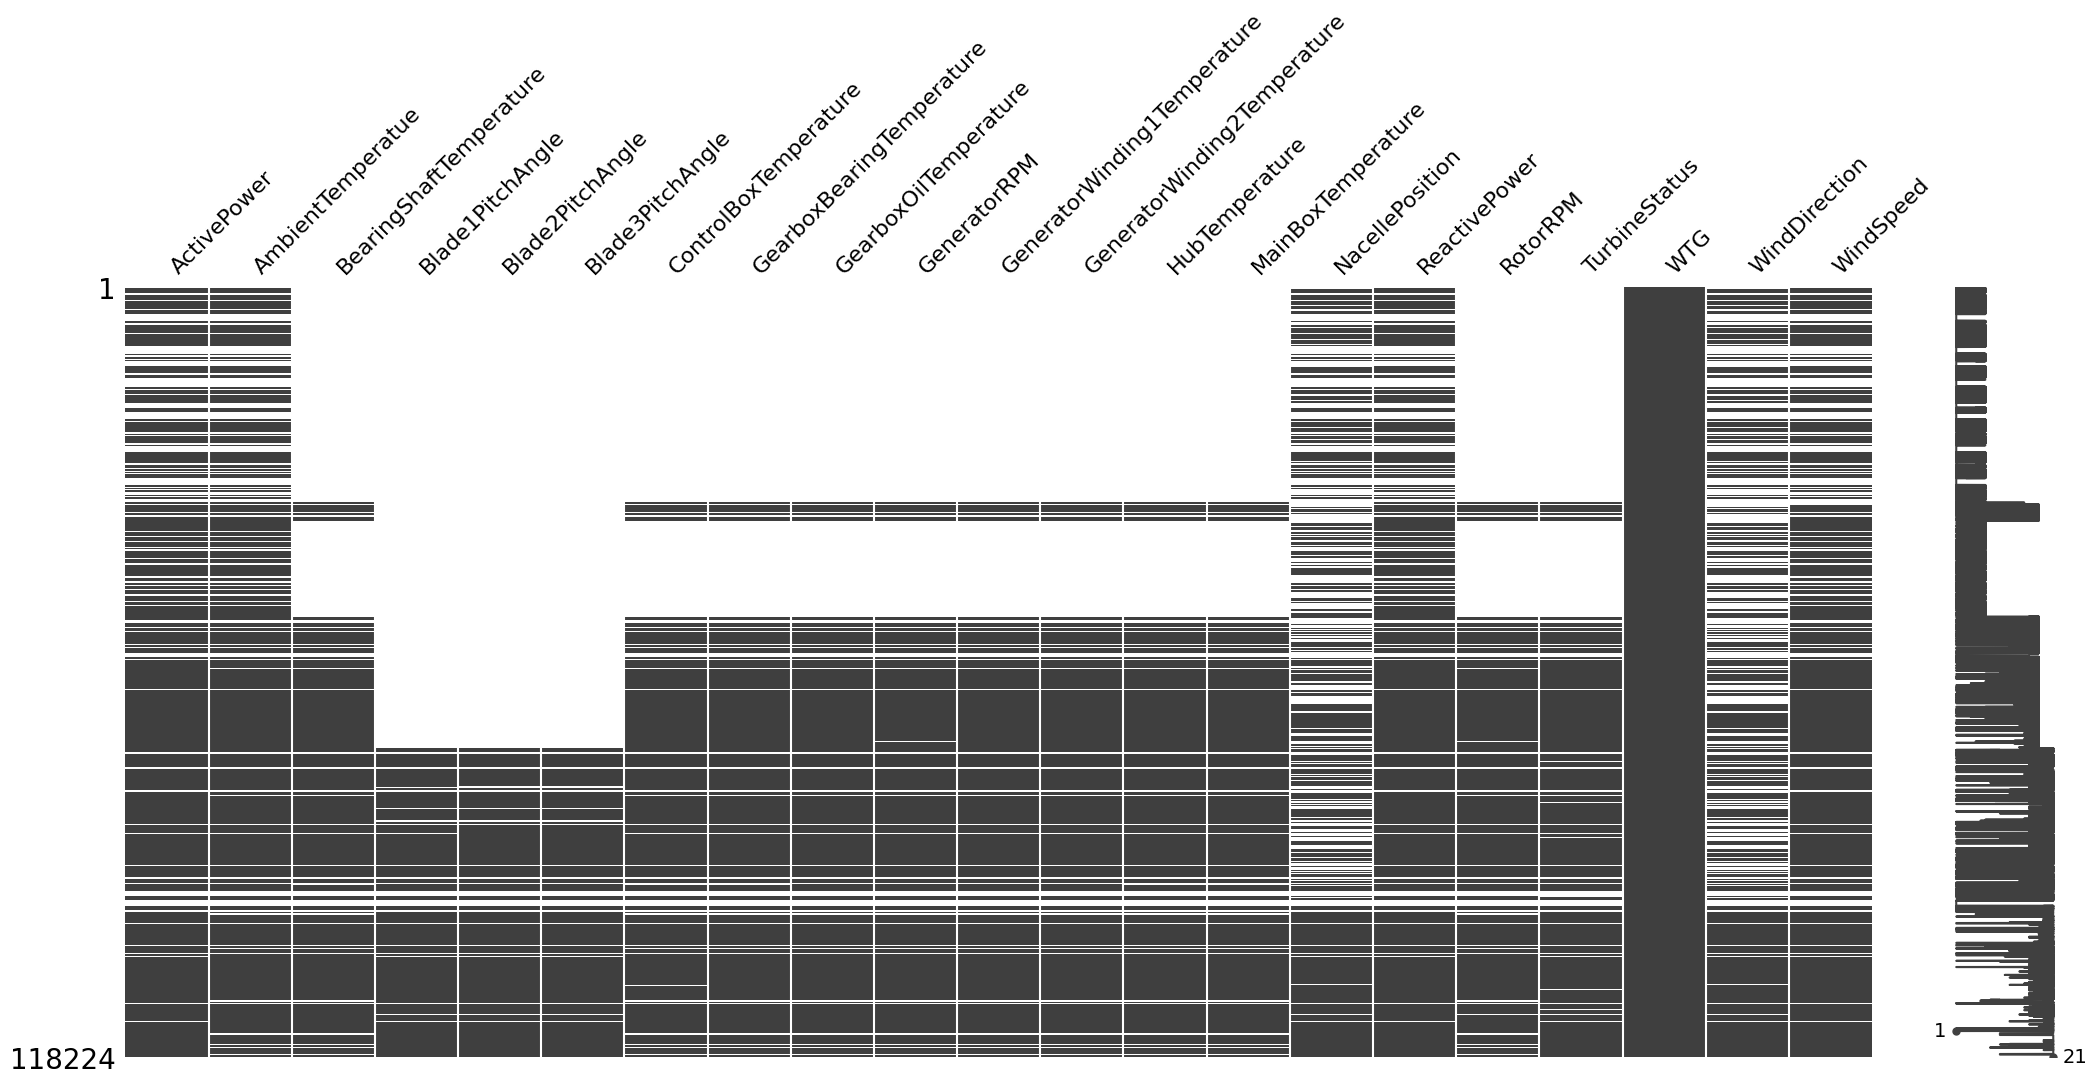

In [9]:
msno.matrix(df)

#### The dataset shows 118224 observations for 22 features but some of the features have significant periods of missing data. We need to discard some periods and fill in the missing periods, otherwise our model will not converge or we may end up feeding it with garbage data.

#### The rightmost part of the msno matrix plot shows completess of data, it indicates that the last half of dataset is more complete.

In [10]:
# dropping all duplicate values
df.drop_duplicates(inplace=True)

In [11]:
df

ActivePower  AmbientTemperatue  \
2017-12-31 00:00:00+00:00          NaN                NaN   
2018-01-01 00:00:00+00:00    -5.357727          23.148729   
2018-01-01 00:10:00+00:00    -5.822360          23.039754   
2018-01-01 00:20:00+00:00    -5.279409          22.948703   
2018-01-01 00:30:00+00:00    -4.648054          22.966851   
...                                ...                ...   
2020-03-30 23:10:00+00:00    70.044465          27.523741   
2020-03-30 23:20:00+00:00    40.833474          27.602882   
2020-03-30 23:30:00+00:00    20.777790          27.560925   
2020-03-30 23:40:00+00:00    62.091039          27.810472   
2020-03-30 23:50:00+00:00    68.664425          27.915828   

                           BearingShaftTemperature  Blade1PitchAngle  \
2017-12-31 00:00:00+00:00                      NaN               NaN   
2018-01-01 00:00:00+00:00                      NaN               NaN   
2018-01-01 00:10:00+00:00                      NaN               NaN   
2018-01-01 00:20:00+00:00                      NaN               NaN   
2018-01-01 00:30:00+00:00                      NaN               NaN   
...                                            ...               ...   
2020-03-30 23:10:00+00:00                45.711129          1.515669   
2020-03-30 23:20:00+00:00                45.598573          1.702809   
2020-03-30 23:30:00+00:00                45.462045          1.706214   
2020-03-30 23:40:00+00:00                45.343827          1.575352   
2020-03-30 23:50:00+00:00                45.231610          1.499323   

                           Blade2PitchAngle  Blade3PitchAngle  \
2017-12-31 00:00:00+00:00               NaN               NaN   
2018-01-01 00:00:00+00:00               NaN               NaN   
2018-01-01 00:10:00+00:00               NaN               NaN   
2018-01-01 00:20:00+00:00               NaN               NaN   
2018-01-01 00:30:00+00:00               NaN               NaN   
...                                     ...               ...   
2020-03-30 23:10:00+00:00          1.950088          1.950088   
2020-03-30 23:20:00+00:00          2.136732          2.136732   
2020-03-30 23:30:00+00:00          2.139664          2.139664   
2020-03-30 23:40:00+00:00          2.009781          2.009781   
2020-03-30 23:50:00+00:00          1.933124          1.933124   

                           ControlBoxTemperature  GearboxBearingTemperature  \
2017-12-31 00:00:00+00:00                    NaN                        NaN   
2018-01-01 00:00:00+00:00                    NaN                        NaN   
2018-01-01 00:10:00+00:00                    NaN                        NaN   
2018-01-01 00:20:00+00:00                    NaN                        NaN   
2018-01-01 00:30:00+00:00                    NaN                        NaN   
...                                          ...                        ...   
2020-03-30 23:10:00+00:00                    0.0                  59.821165   
2020-03-30 23:20:00+00:00                    0.0                  59.142038   
2020-03-30 23:30:00+00:00                    0.0                  58.439439   
2020-03-30 23:40:00+00:00                    0.0                  58.205413   
2020-03-30 23:50:00+00:00                    0.0                  58.581716   

                           GearboxOilTemperature  GeneratorRPM  \
2017-12-31 00:00:00+00:00                    NaN           NaN   
2018-01-01 00:00:00+00:00                    NaN           NaN   
2018-01-01 00:10:00+00:00                    NaN           NaN   
2018-01-01 00:20:00+00:00                    NaN           NaN   
2018-01-01 00:30:00+00:00                    NaN           NaN   
...                                          ...           ...   
2020-03-30 23:10:00+00:00              55.193793   1029.870744   
2020-03-30 23:20:00+00:00              54.798545   1030.160478   
2020-03-30 23:30:00+00:00              54.380456   1030.137822   
2020-03-30 23:40:00+00:00              

In [12]:
df.shape

(95185, 21)

In [13]:
df.nunique()

ActivePower                     94084
AmbientTemperatue               93678
BearingShaftTemperature         62286
Blade1PitchAngle                38946
Blade2PitchAngle                39021
Blade3PitchAngle                39021
ControlBoxTemperature               1
GearboxBearingTemperature       62313
GearboxOilTemperature           62412
GeneratorRPM                    61074
GeneratorWinding1Temperature    62406
GeneratorWinding2Temperature    62424
HubTemperature                  38119
MainBoxTemperature              49145
NacellePosition                  6664
ReactivePower                   94040
RotorRPM                        59254
TurbineStatus                     353
WTG                                 1
WindDirection                    6664
WindSpeed                       94224
dtype: int64

In [14]:
# dropping WTG and ControlBoxTemperature as they have only 1 unique value and they will contribute nothing to the accuracy model
df.drop(columns=['ControlBoxTemperature', 'WTG'], inplace=True)

In [15]:
df.shape

(95185, 19)

In [16]:
df.head()

ActivePower  AmbientTemperatue  \
2017-12-31 00:00:00+00:00          NaN                NaN   
2018-01-01 00:00:00+00:00    -5.357727          23.148729   
2018-01-01 00:10:00+00:00    -5.822360          23.039754   
2018-01-01 00:20:00+00:00    -5.279409          22.948703   
2018-01-01 00:30:00+00:00    -4.648054          22.966851   

                           BearingShaftTemperature  Blade1PitchAngle  \
2017-12-31 00:00:00+00:00                      NaN               NaN   
2018-01-01 00:00:00+00:00                      NaN               NaN   
2018-01-01 00:10:00+00:00                      NaN               NaN   
2018-01-01 00:20:00+00:00                      NaN               NaN   
2018-01-01 00:30:00+00:00                      NaN               NaN   

                           Blade2PitchAngle  Blade3PitchAngle  \
2017-12-31 00:00:00+00:00               NaN               NaN   
2018-01-01 00:00:00+00:00               NaN               NaN   
2018-01-01 00:10:00+00:00               NaN               NaN   
2018-01-01 00:20:00+00:00               NaN               NaN   
2018-01-01 00:30:00+00:00               NaN               NaN   

                           GearboxBearingTemperature  GearboxOilTemperature  \
2017-12-31 00:00:00+00:00                        NaN                    NaN   
2018-01-01 00:00:00+00:00                        NaN                    NaN   
2018-01-01 00:10:00+00:00                        NaN                    NaN   
2018-01-01 00:20:00+00:00                        NaN                    NaN   
2018-01-01 00:30:00+00:00                        NaN                    NaN   

                           GeneratorRPM  GeneratorWinding1Temperature  \
2017-12-31 00:00:00+00:00           NaN                           NaN   
2018-01-01 00:00:00+00:00           NaN                           NaN   
2018-01-01 00:10:00+00:00           NaN                           NaN   
2018-01-01 00:20:00+00:00           NaN                           NaN   
2018-01-01 00:30:00+00:00           NaN                           NaN   

                           GeneratorWinding2Temperature  HubTemperature  \
2017-12-31 00:00:00+00:00                           NaN             NaN   
2018-01-01 00:00:00+00:00                           NaN             NaN   
2018-01-01 00:10:00+00:00                           NaN             NaN   
2018-01-01 00:20:00+00:00                           NaN             NaN   
2018-01-01 00:30:00+00:00                           NaN             NaN   

                           MainBoxTemperature  NacellePosition  ReactivePower  \
2017-12-31 00:00:00+00:00                 NaN              NaN            NaN   
2018-01-01 00:00:00+00:00                 NaN         8.000000      -9.960830   
2018-01-01 00:10:00+00:00                 NaN       300.428571      -9.628441   
2018-01-01 00:20:00+00:00                 NaN       340.000000      -9.491235   
2018-01-01 00:30:00+00:00                 NaN       345.000000      -9.856136   

                           RotorRPM  TurbineStatus  WindDirection  WindSpeed  
2017-12-31 00:00:00+00:00       NaN            NaN            NaN        NaN  
2018-01-01 00:00:00+00:00       NaN            NaN       8.000000   2.279088  
2018-01-01 00:10:00+00:00       NaN            NaN     300.428571   2.339343  
2018-01-01 00:20:00+00:00       NaN            NaN     340.000000   2.455610  
2018-01-01 00:30:00+00:00       NaN            NaN     345.000000   2.026754

In [17]:
df.describe()

ActivePower  AmbientTemperatue  BearingShaftTemperature  \
count  94624.000000       93698.000000             62380.000000   
mean     619.036994          28.777569                43.105338   
std      610.917748           4.358470                 5.168850   
min      -38.524659           0.000000                 0.000000   
25%       80.098952          25.625603                39.856871   
50%      402.880706          28.338961                42.927465   
75%     1073.979105          31.665910                47.018075   
max     1779.032433          42.405597                55.088655   

       Blade1PitchAngle  Blade2PitchAngle  Blade3PitchAngle  \
count      41987.000000      41882.000000      41882.000000   
mean           9.751759         10.038709         10.038709   
std           20.646533         20.272100         20.272100   
min          -43.156734        -26.443415        -26.443415   
25%           -0.939896         -0.433316         -0.433316   
50%            0.395038          0.889782          0.889782   
75%            8.101939          8.481306          8.481306   
max           90.143610         90.017830         90.017830   

       GearboxBearingTemperature  GearboxOilTemperature  GeneratorRPM  \
count               62402.000000           62430.000000  62287.000000   
mean                   64.376222              57.561706   1102.146658   
std                    10.020754               6.324124    527.967896   
min                     0.000000               0.000000      0.000000   
25%                    57.925129              53.944023   1029.812895   
50%                    64.862406              57.197064   1124.930500   
75%                    71.104401              61.307270   1515.517020   
max                    82.237932              70.764581   1809.941700   

       GeneratorWinding1Temperature  GeneratorWinding2Temperature  \
count                  62419.000000                  62441.000000   
mean                      72.462897                     71.829134   
std                       22.626685                     22.649494   
min                        0.000000                      0.000000   
25%                       55.492241                     54.763998   
50%                       65.792061                     65.006679   
75%                       85.874609                     85.342714   
max                      126.773031                    126.043018   

       HubTemperature  MainBoxTemperature  NacellePosition  ReactivePower  \
count    62268.000000        62369.000000     72108.000000   94622.000000   
mean        36.979752           39.635107       196.307894      88.070309   
std          4.884101            5.428555        88.279316     116.498176   
min          0.000000            0.000000         0.000000    -203.182591   
25%         33.977709           35.843574       145.000000      -0.433723   
50%         37.003815           39.500759       182.000000      35.938526   
75%         40.009538           43.370342       271.000000     147.190453   
max         47.996185           54.250000       357.000000     403.713620   

           RotorRPM  TurbineStatus  WindDirection     WindSpeed  
count  62119.000000   6.275900e+04   72108.000000  94469.000000  
mean       9.908585   2.284016e+03     196.307894      5.879193  
std        4.717546   3.590288e+05      88.279316      2.617241  
min        0.000000   0.000000e+00       0.000000      0.000000  
25%        9.231097   2.000000e+00     145.000000      3.824572  
50%       10.099272   2.000000e+00     182.000000      5.558520  
75%       13.600908   2.000000e+00     271.000000      7.505555  
max       16.273495   6.574653e+07     357.000000     22.970893

In [18]:
# In the above table, we can see that the ActivePower column consists of negative values. As the power can never be negative.
df = df[df['ActivePower']>=0]

In [19]:
df.shape

(78989, 19)

In [20]:
df.isna().sum()

ActivePower                         0
AmbientTemperatue                1032
BearingShaftTemperature         26821
Blade1PitchAngle                43282
Blade2PitchAngle                43365
Blade3PitchAngle                43365
GearboxBearingTemperature       26819
GearboxOilTemperature           26806
GeneratorRPM                    26810
GeneratorWinding1Temperature    26792
GeneratorWinding2Temperature    26785
HubTemperature                  26930
MainBoxTemperature              26841
NacellePosition                 20429
ReactivePower                      42
RotorRPM                        26816
TurbineStatus                   26466
WindDirection                   20429
WindSpeed                         308
dtype: int64

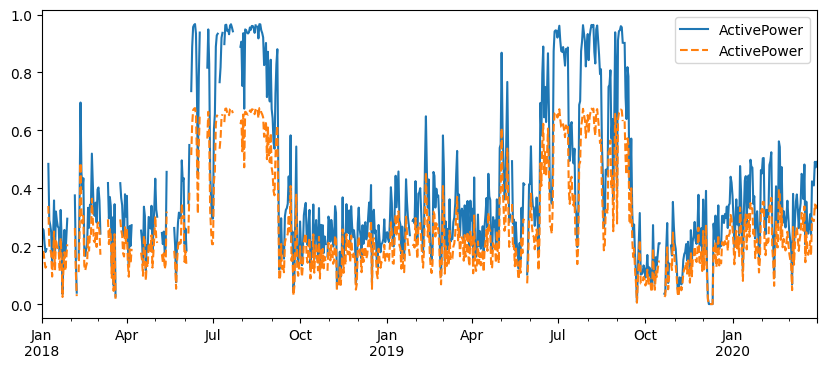

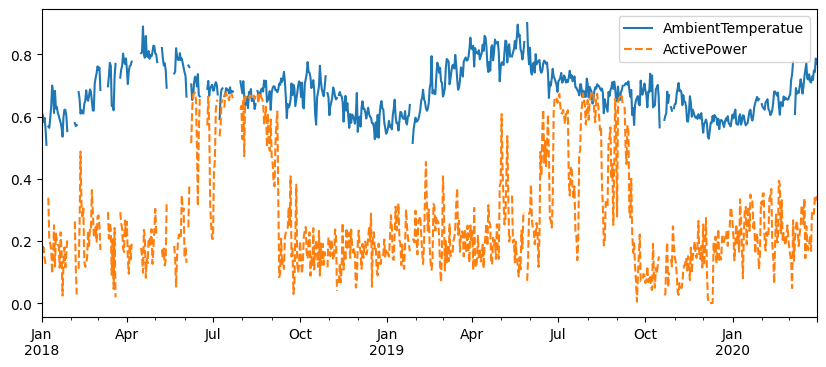

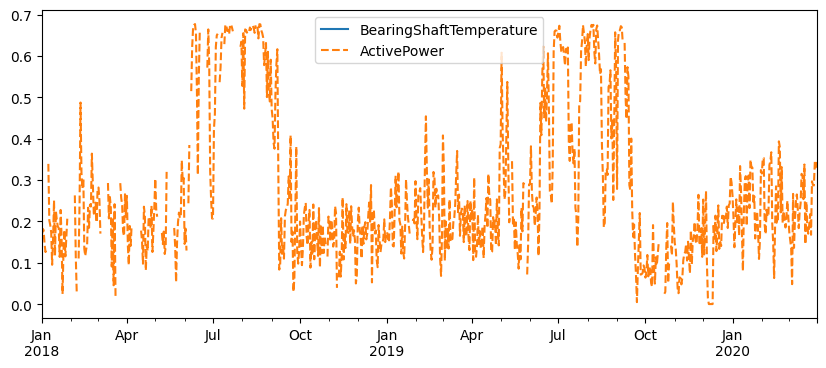

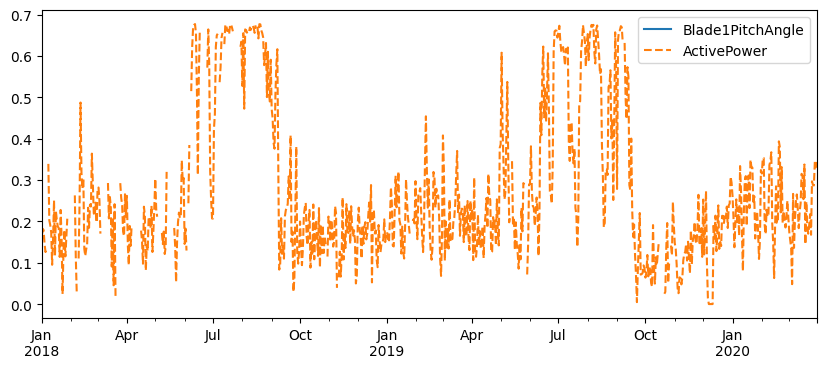

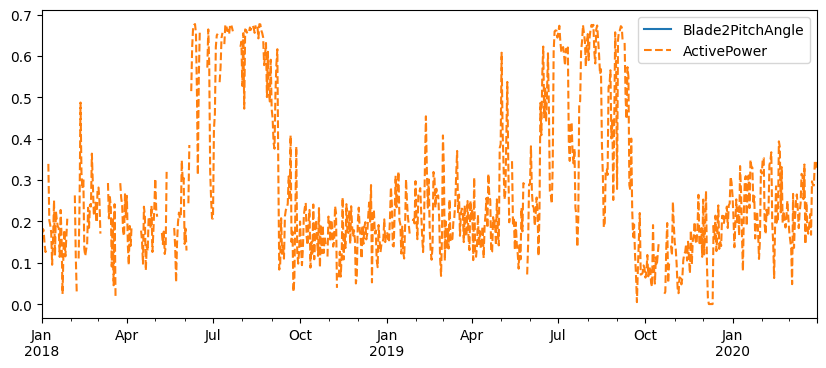

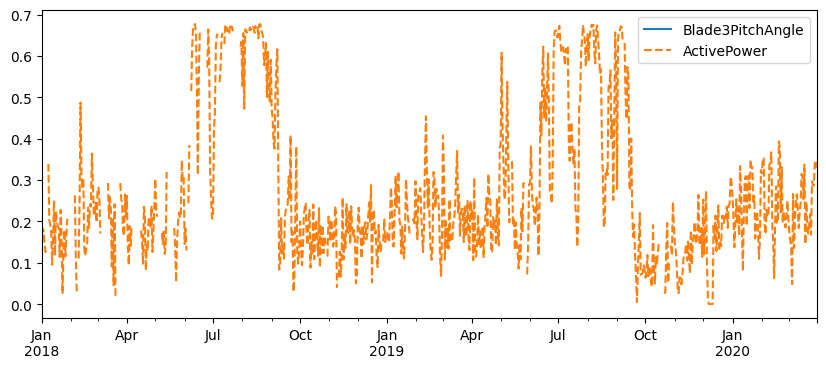

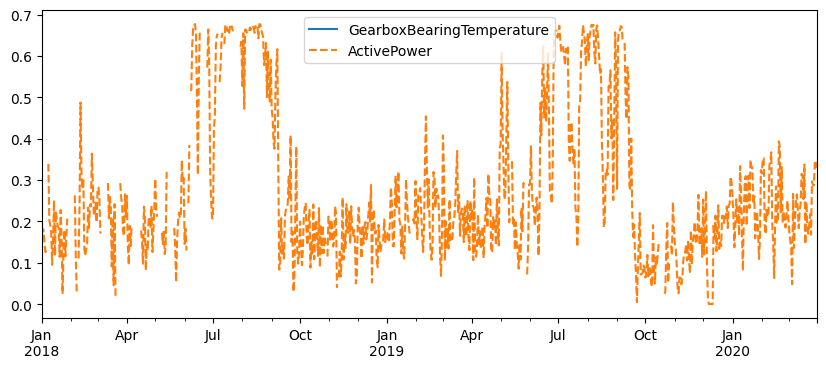

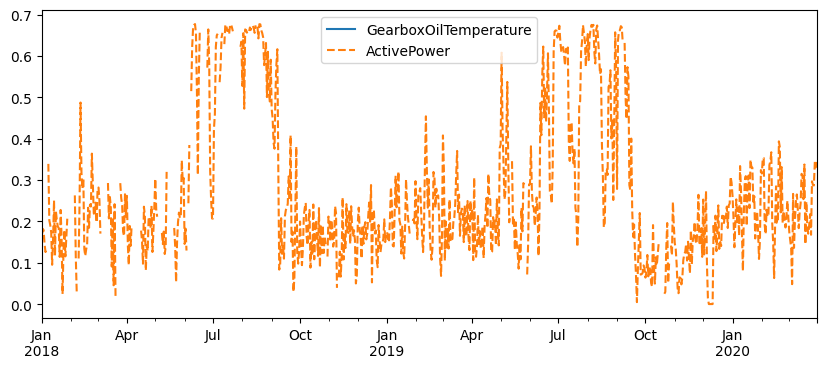

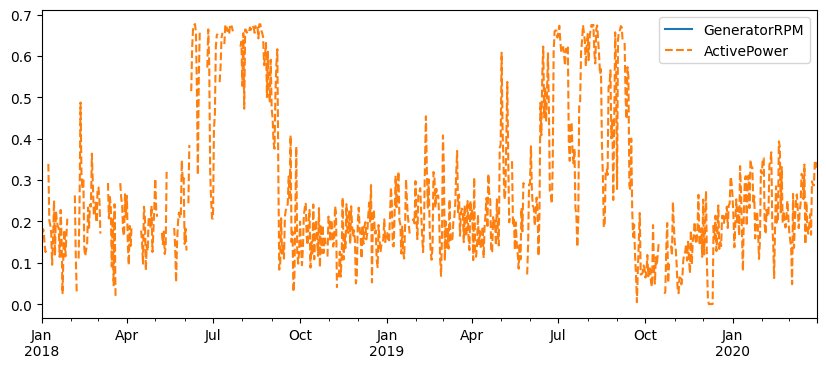

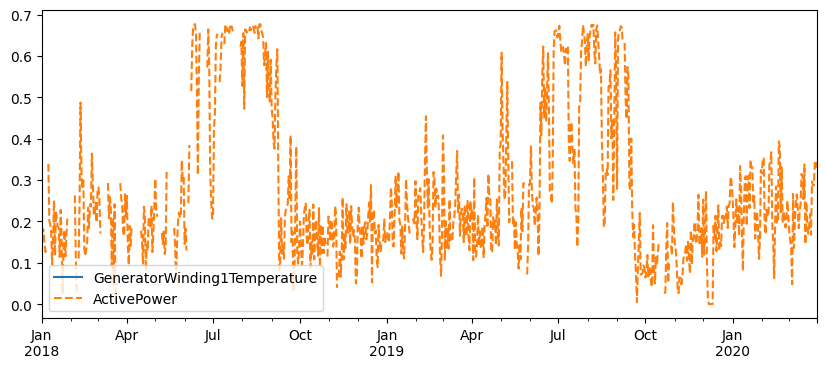

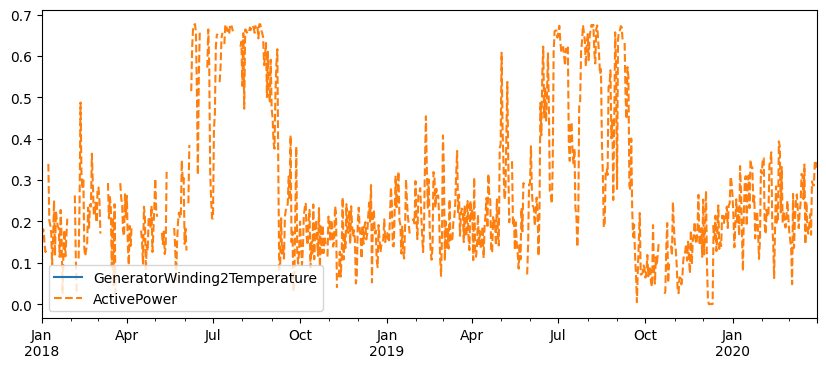

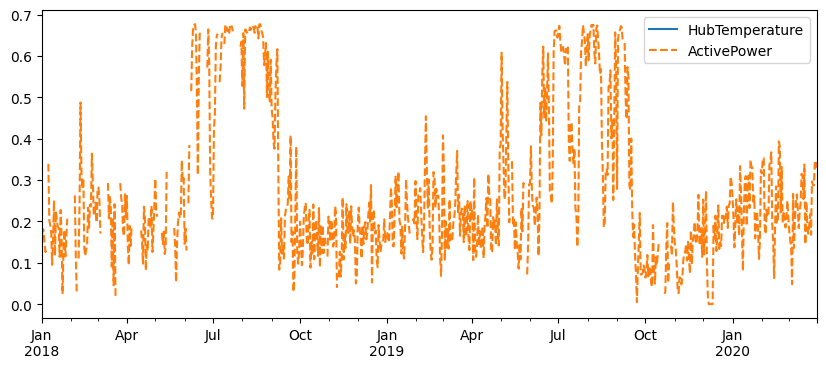

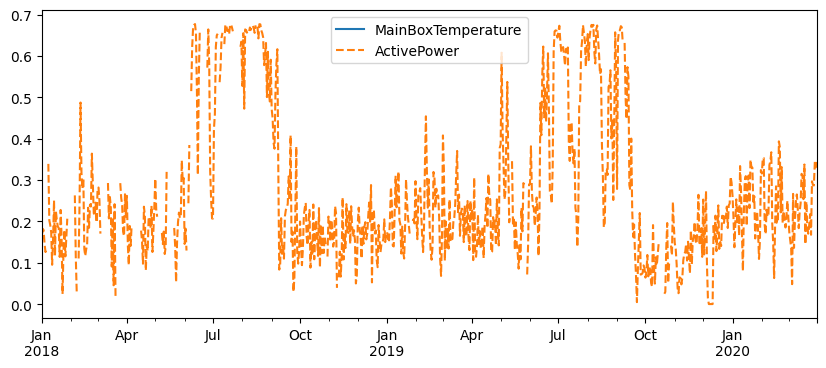

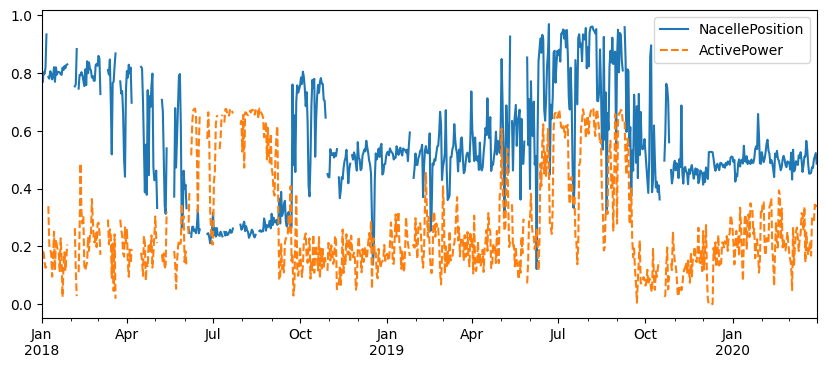

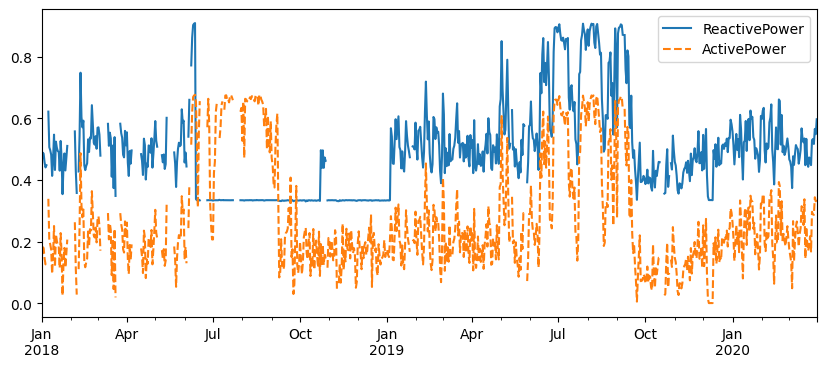

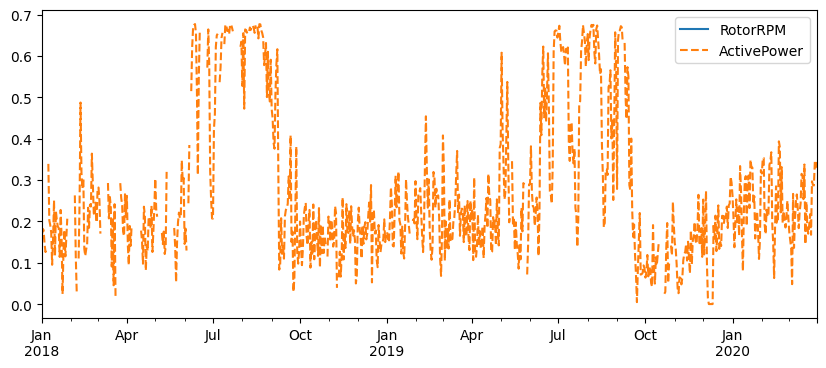

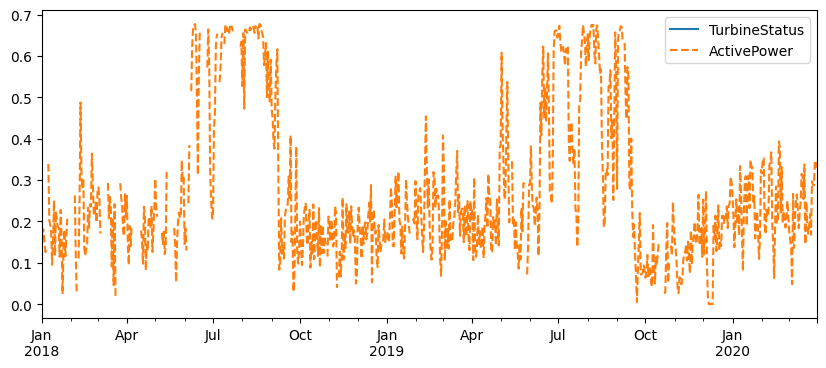

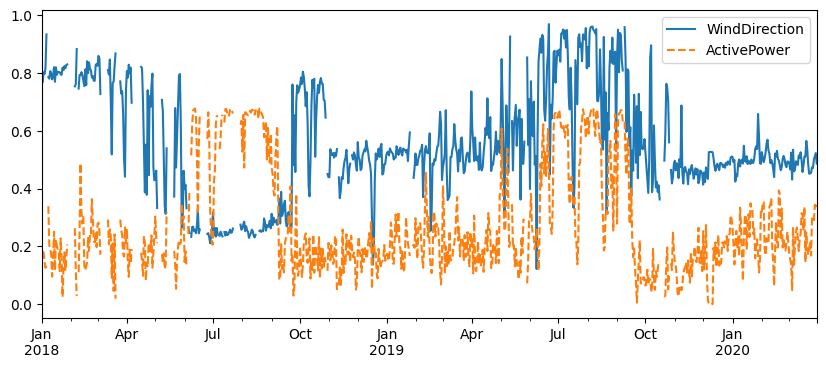

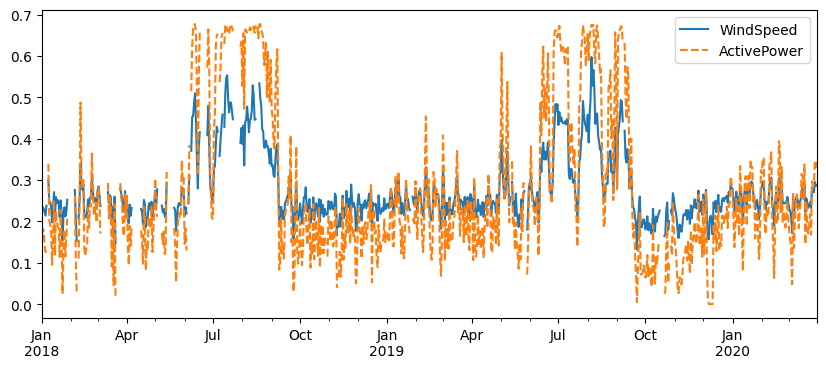

In [21]:
data = df.copy()
for i in df:
    mini = min(data[i])
    maxi = max(data[i])
    data[i] = (data[i] - mini)/(maxi - mini)

    plt.figure(figsize=(10, 4))
    data[i].resample('D').mean().plot(label=i)
    (data['ActivePower']*0.7).resample('D').mean().plot(style='--', label='ActivePower')
    plt.legend()
    plt.show()

### In the provided graph, only WindSpeed and ActivePower exhibit a positive correlation. As wind speed increases from June to October, ActivePower also increases.

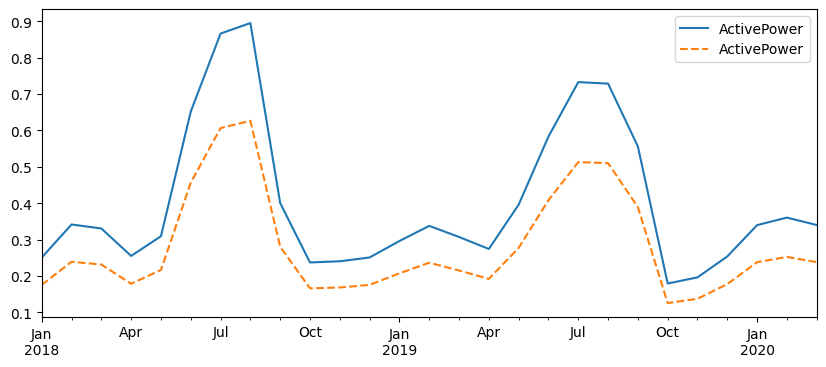

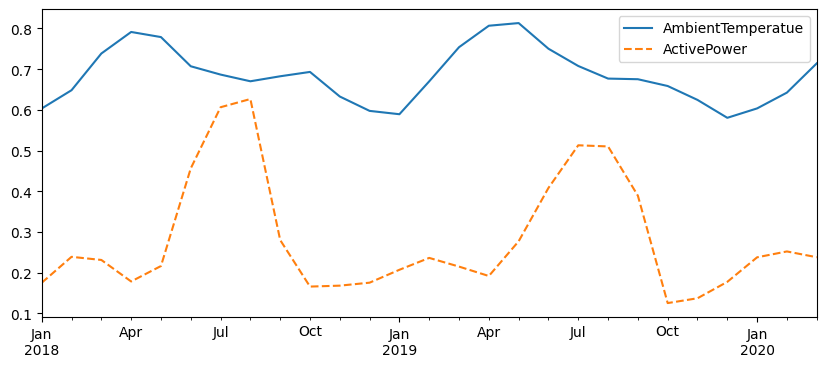

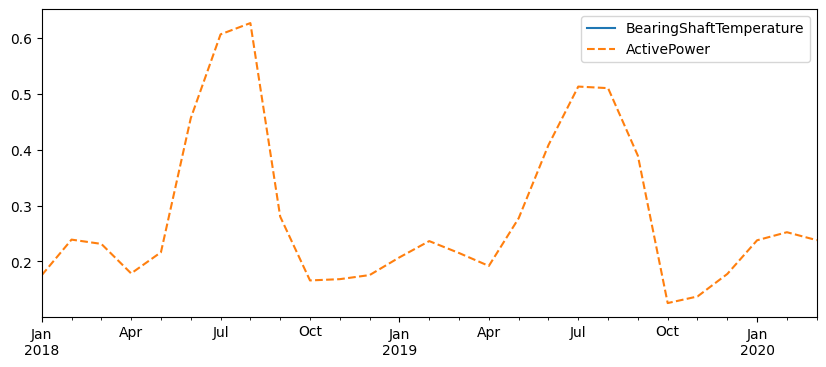

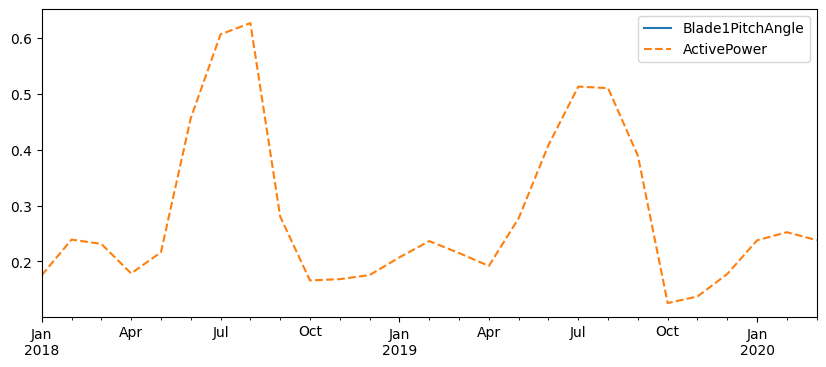

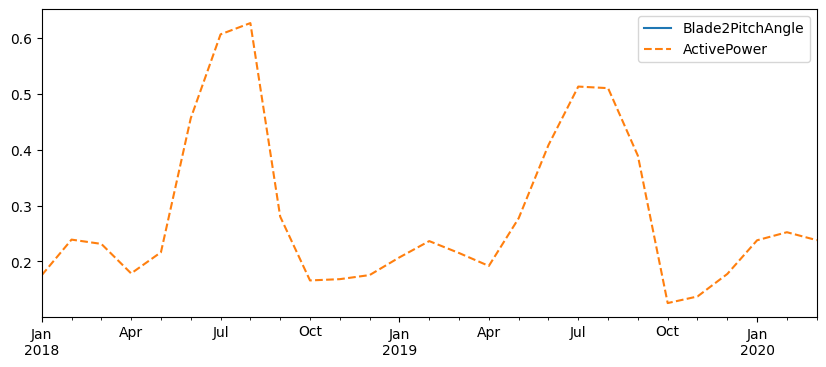

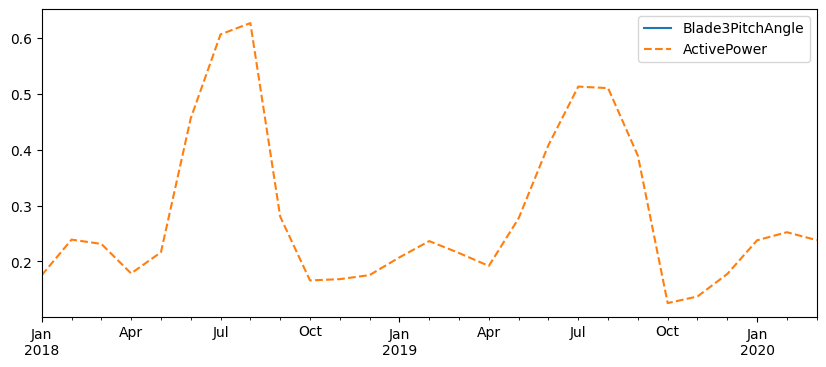

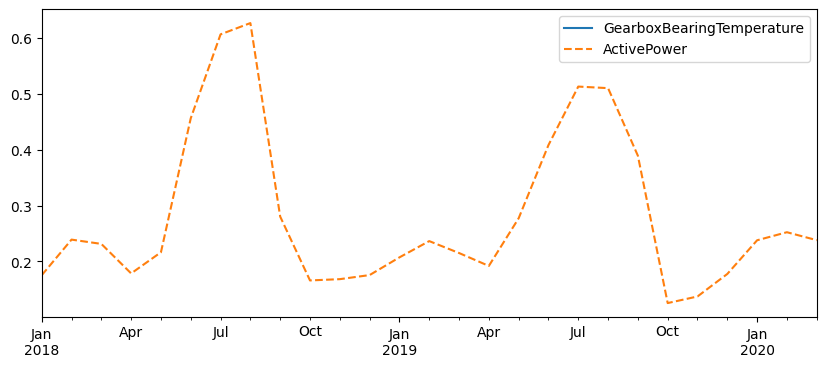

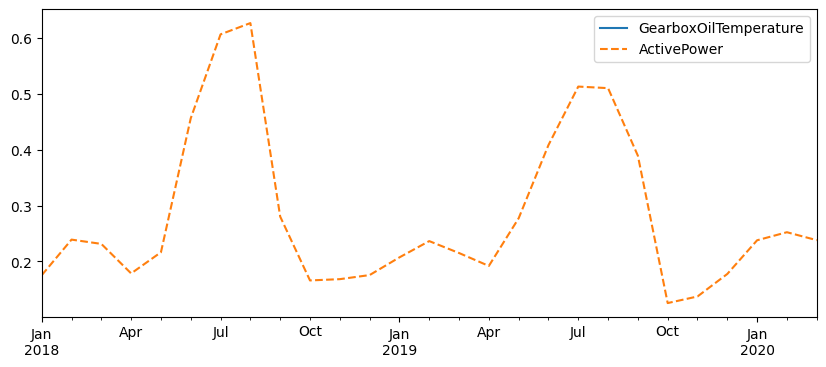

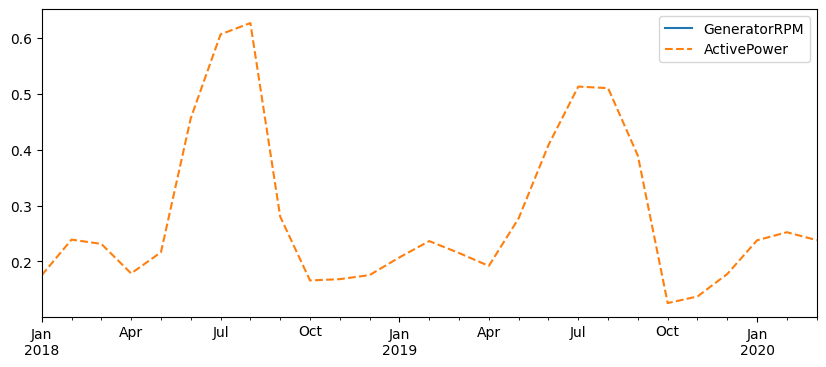

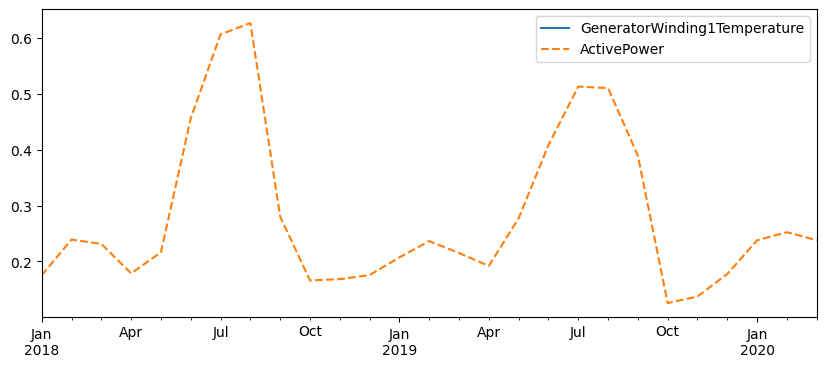

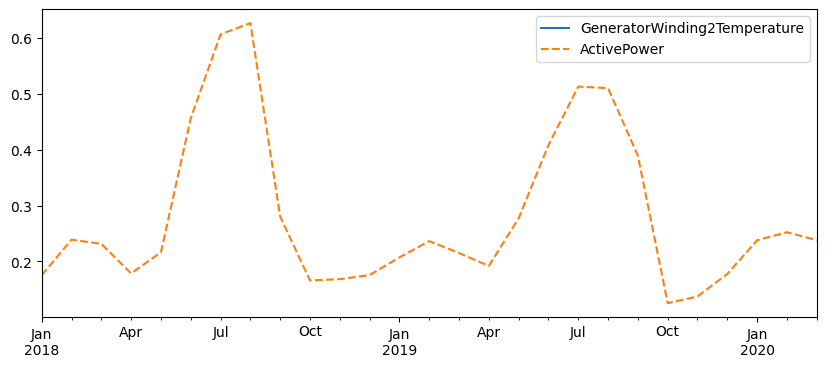

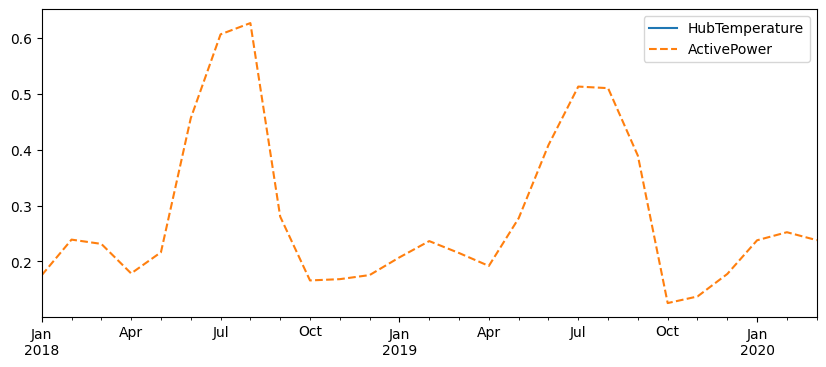

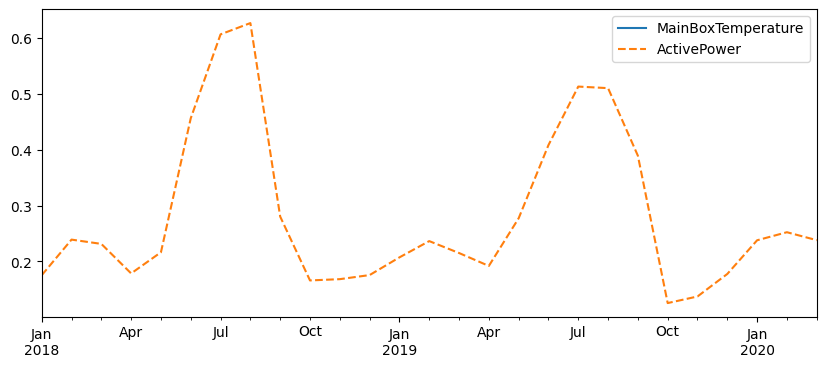

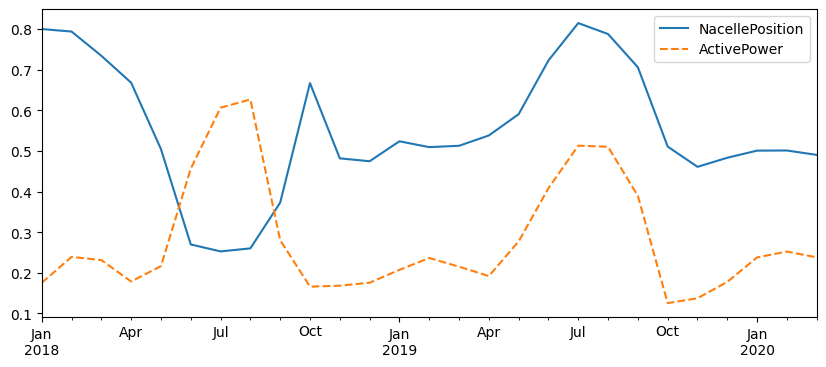

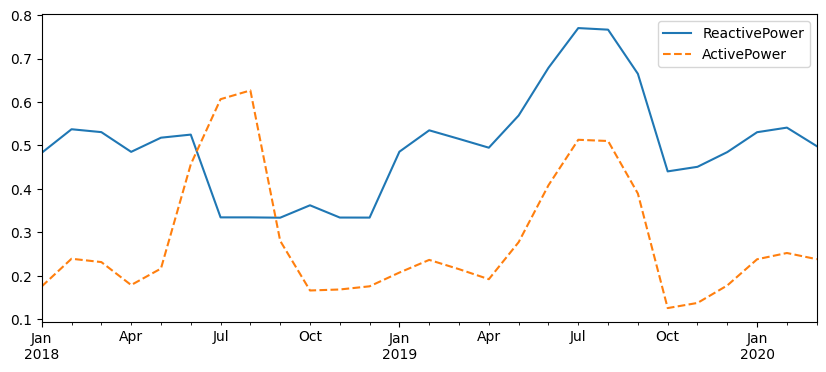

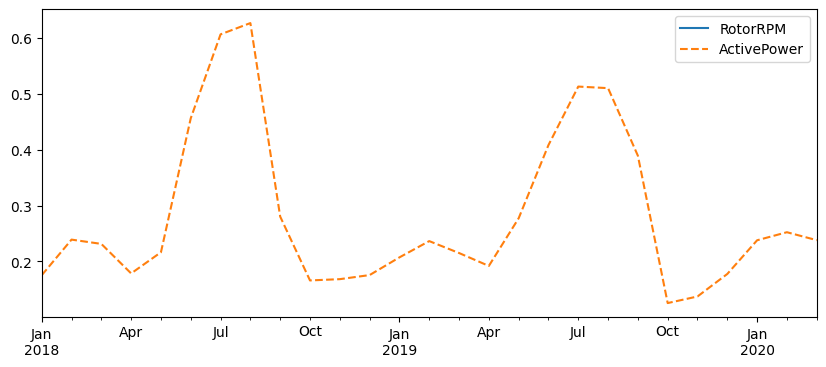

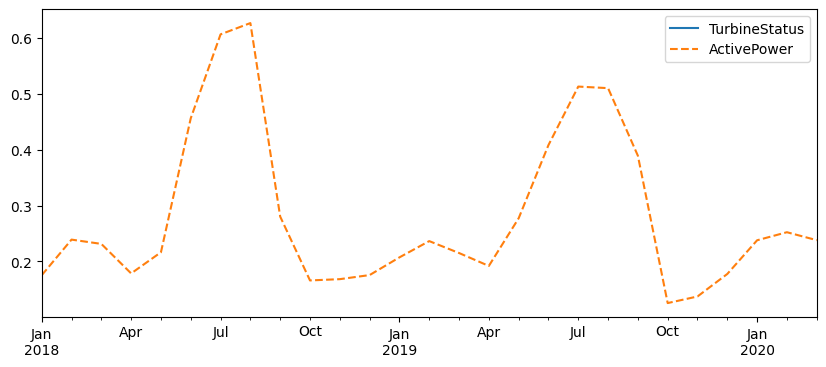

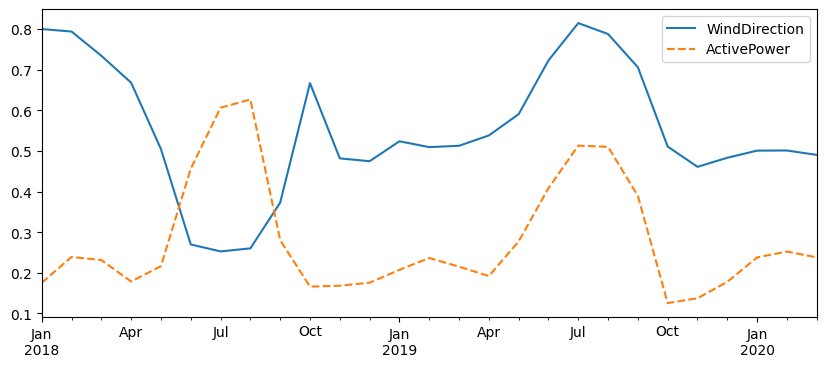

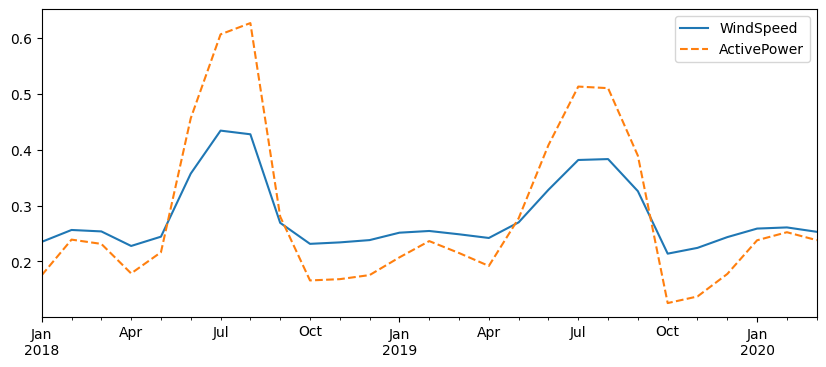

In [22]:
for i in data:
    plt.figure(figsize=(10, 4))
    data[i].resample('M').mean().plot(label=i)
    (data['ActivePower']*0.7).resample('M').mean().plot(style='--', label='ActivePower')
    plt.legend()
    plt.show()

<Axes: >

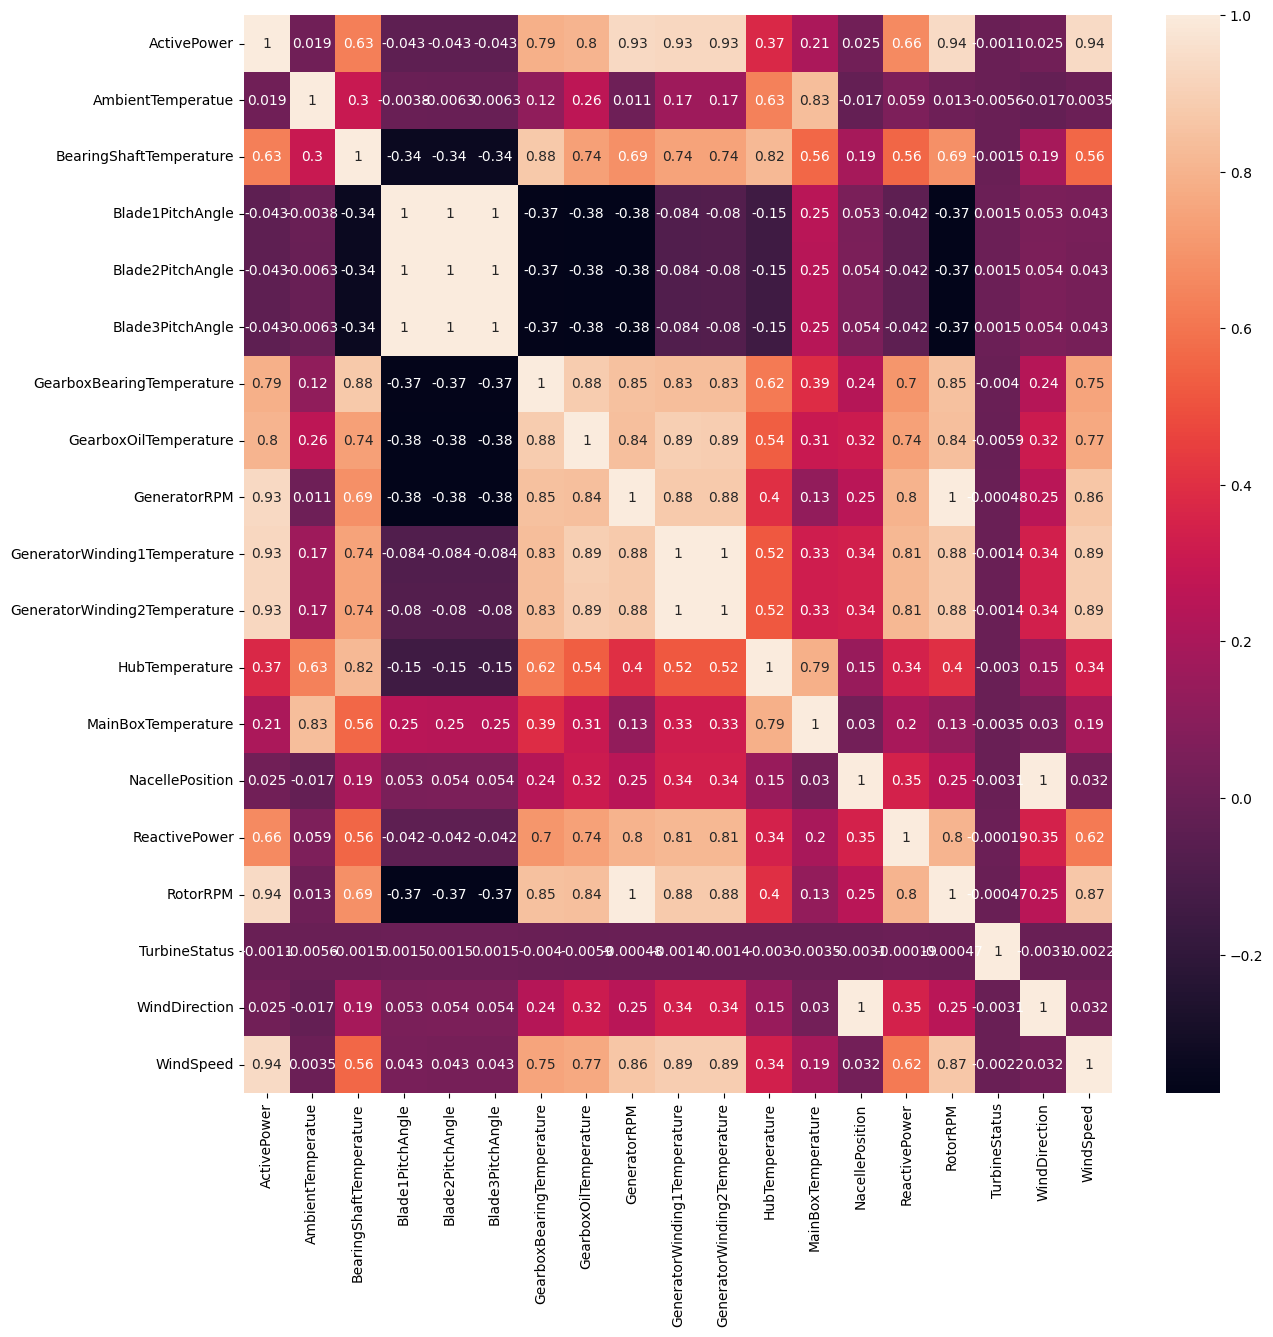

In [23]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.corr(), annot=True)

#### The correlation plot indicates a significant positive correlation among multiple features, suggesting redundancy within the dataset. To enhance model performance and mitigate the curse of dimensionality, it is imperative to discard redundant features. This reduction will streamline the dataset, improving computational efficiency and the interpretability of the model. Focusing on the most informative variables will facilitate more robust predictive capabilities and ensure more reliable outcomes in subsequent analyses.

In [24]:
df = df[['WindSpeed', 'ActivePower']]

In [25]:
df.describe()

WindSpeed   ActivePower
count  78681.000000  78989.000000
mean       6.508584    742.779831
std        2.380567    595.334913
min        0.000000      0.000000
25%        4.694561    225.562517
50%        6.104735    555.505381
75%        7.938625   1269.581314
max       22.970893   1779.032433

In [26]:
df[df['WindSpeed']>=5]

WindSpeed  ActivePower
2018-01-01 13:30:00+00:00   5.276923   343.909751
2018-01-01 13:50:00+00:00   5.196896   322.298799
2018-01-01 14:00:00+00:00   5.307421   340.236740
2018-01-01 16:00:00+00:00   5.268914   347.094710
2018-01-01 16:10:00+00:00   5.983094   534.837806
...                              ...          ...
2020-03-30 20:20:00+00:00   6.180194   569.799017
2020-03-30 20:30:00+00:00   5.867367   461.937721
2020-03-30 20:40:00+00:00   5.772210   434.807011
2020-03-30 20:50:00+00:00   5.684183   403.058877
2020-03-30 21:00:00+00:00   5.152047   301.834096

[54802 rows x 2 columns]

In [27]:
df[df.isna().any(axis=1)]

WindSpeed  ActivePower
2018-02-05 04:40:00+00:00        NaN   604.707600
2018-03-18 11:30:00+00:00        NaN   616.750500
2018-04-29 04:20:00+00:00        NaN   208.700130
2018-05-23 12:50:00+00:00        NaN    64.252914
2018-08-17 14:50:00+00:00        NaN  1719.467111
...                              ...          ...
2019-08-06 09:00:00+00:00        NaN  1716.844917
2019-08-06 09:10:00+00:00        NaN  1738.946384
2019-08-06 09:20:00+00:00        NaN  1698.711900
2019-08-06 09:40:00+00:00        NaN  1717.949712
2019-08-06 09:50:00+00:00        NaN  1719.177737

[308 rows x 2 columns]

<Axes: >

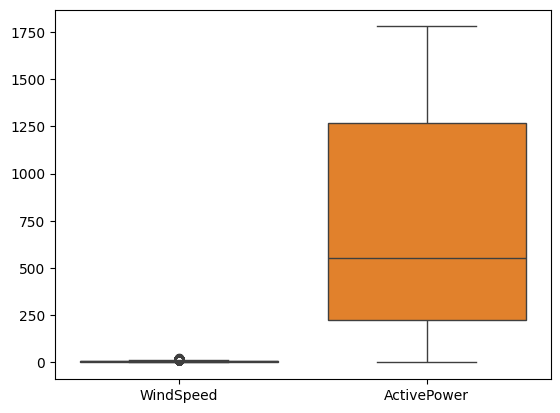

In [28]:
sns.boxplot(df)

<Axes: title={'center': 'Missing WindSpeed Over Time'}>

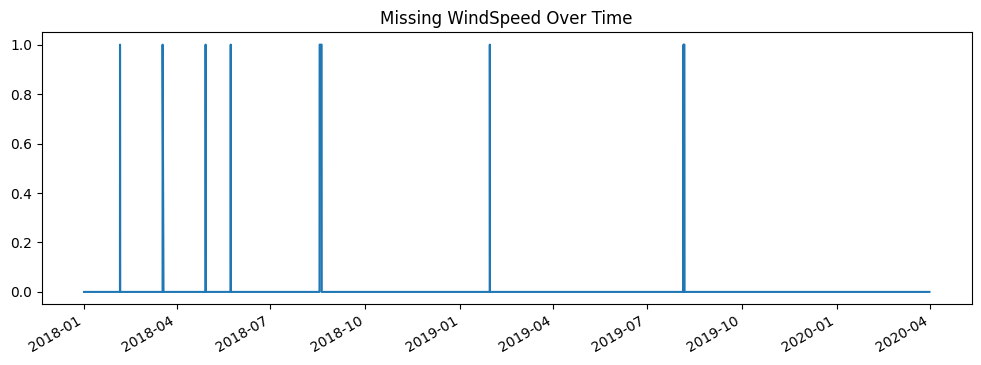

In [29]:
df['WindSpeed'].isna().astype(int).plot(figsize=(12, 4), title="Missing WindSpeed Over Time")

In [30]:
# Wind speed is typically continuous and smooth over time (except during storms or gusts), so interpolation is the most realistic fix.
df['WindSpeed'] = df['WindSpeed'].interpolate(method='time')

In [31]:
df.isna().sum()

WindSpeed      0
ActivePower    0
dtype: int64

In [32]:
df.shape

(78989, 2)

In [33]:
X_train, X_test, y_train, y_test = df['WindSpeed'][:78000], df['WindSpeed'][78000:], df['ActivePower'][:78000], df['ActivePower'][78000:]

In [34]:
len(X_train), len(X_test), len(y_train), len(y_test)

(78000, 989, 78000, 989)

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200, 250],
    'colsample_bytree': [0.7, 0.8, 1]
}
grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, error_score='raise')
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interact...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='neg_mean_squared_error')

In [36]:
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 150}

In [37]:
model = xgb.XGBRegressor(n_estimators = 150, max_depth = 3, subsample = 0.7, learning_rate = 0.05, colsample_bytree = 0.7)

In [38]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:567.38364	validation_1-rmse:489.08448


[1]	validation_0-rmse:539.94664	validation_1-rmse:466.18556
[2]	validation_0-rmse:513.90013	validation_1-rmse:444.42889
[3]	validation_0-rmse:489.19212	validation_1-rmse:423.71520
[4]	validation_0-rmse:465.72146	validation_1-rmse:404.05340
[5]	validation_0-rmse:443.48230	validation_1-rmse:385.45616
[6]	validation_0-rmse:422.37608	validation_1-rmse:367.78248
[7]	validation_0-rmse:402.33756	validation_1-rmse:350.95036
[8]	validation_0-rmse:383.29796	validation_1-rmse:334.96787
[9]	validation_0-rmse:365.26855	validation_1-rmse:319.88631
[10]	validation_0-rmse:348.19134	validation_1-rmse:305.73708
[11]	validation_0-rmse:331.99419	validation_1-rmse:292.24927
[12]	validation_0-rmse:316.65063	validation_1-rmse:279.44783
[13]	validation_0-rmse:302.10511	validation_1-rmse:267.23163
[14]	validation_0-rmse:288.35169	validation_1-rmse:255.90930
[15]	validation_0-rmse:275.31893	validation_1-rmse:245.11801
[16]	validation_0-rmse:263.00929	validation_1-rmse:235.07259
[17]	validation_0-rmse:251.31365	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)

In [39]:
pred = model.predict(X_test)

In [40]:
df_final = pd.DataFrame(data={'Actuals': y_test, 'Predictions': pred})

In [41]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [42]:
print(f"The Coefficient of determination (R-Squared): {round(r2_score(df_final['Actuals'], df_final['Predictions']), 3)}")
print(f"Mean Absolute Error (MAE): {round(mean_absolute_error(df_final['Actuals'], df_final['Predictions']), 3)}")
print(f"Mean Squared Error (MSE): {round(mean_squared_error(df_final['Actuals'], df_final['Predictions']), 3)}")
print(f"Root Mean Squared Error (MSE): {round(np.sqrt(mean_squared_error(df_final['Actuals'], df_final['Predictions'])), 3)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mean_absolute_percentage_error(df_final['Actuals'], df_final['Predictions']), 3)}")

The Coefficient of determination (R-Squared): 0.97
Mean Absolute Error (MAE): 63.071
Mean Squared Error (MSE): 7875.179
Root Mean Squared Error (MSE): 88.742
Mean Absolute Percentage Error (MAPE): 0.479


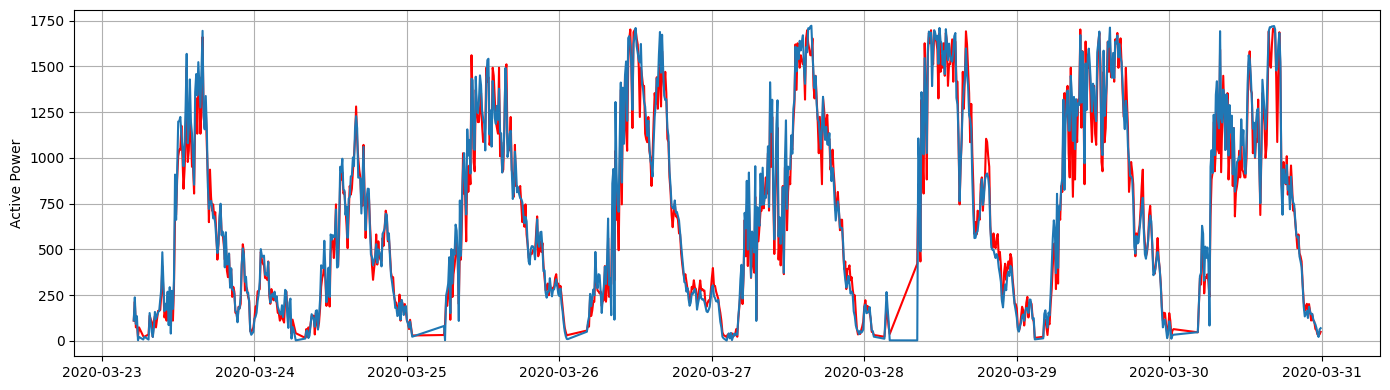

In [43]:
plt.figure(figsize=(14, 4))
plt.plot(df_final['Predictions'], label='Prediction', color = 'red')
plt.plot(df_final['Actuals'], label='Actual')

plt.ylabel('Active Power')
plt.tight_layout()
plt.grid()
plt.show()

<Axes: ylabel='ActivePower'>

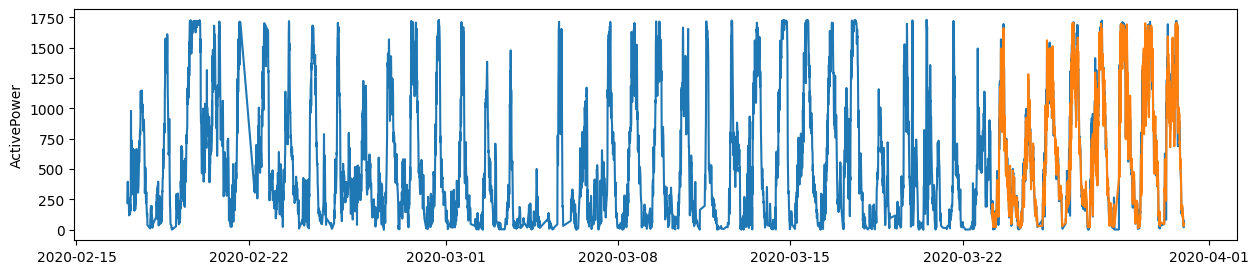

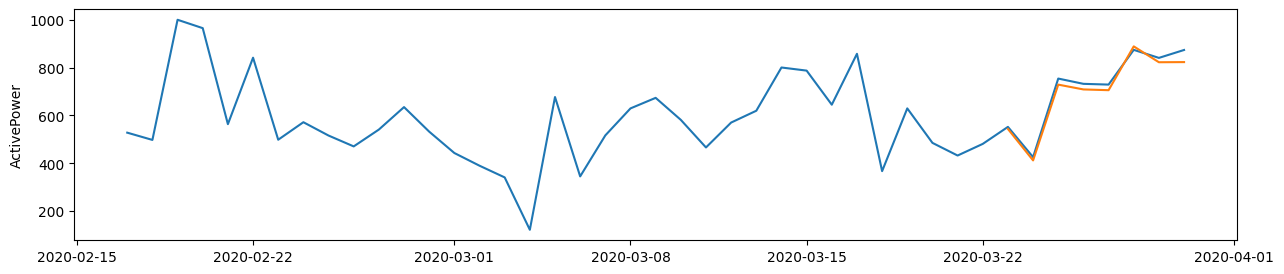

In [44]:
plt.figure(figsize=(15, 3))
sns.lineplot(data=df['ActivePower'][74000:])
sns.lineplot(data = df_final['Predictions'])

plt.figure(figsize=(15, 3))
sns.lineplot(data = df['ActivePower'][74000:].resample('D').mean())
sns.lineplot(data = df_final['Predictions'].resample('D').mean())

## New Test

In [46]:
# Generating new features for the model to train on
def create_features(df):
    df = df.copy()
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayofWeek'] = df.index.dayofweek
    df['DayofYear'] = df.index.dayofyear
    df['WeekofYear'] = df.index.isocalendar().week

    return df

In [47]:
data2 = df.copy()
data2 = create_features(data2)

In [48]:
data2.head()

WindSpeed  ActivePower  Hour  Minute  Day  Month  \
2018-01-01 06:20:00+00:00   3.042750    26.212347     6      20    1      1   
2018-01-01 06:40:00+00:00   3.424814    59.632658     6      40    1      1   
2018-01-01 06:50:00+00:00   3.507172    40.889650     6      50    1      1   
2018-01-01 10:40:00+00:00   3.442212    34.398111    10      40    1      1   
2018-01-01 12:00:00+00:00   3.031363    29.797653    12       0    1      1   

                           Year  DayofWeek  DayofYear  WeekofYear  
2018-01-01 06:20:00+00:00  2018          0          1           1  
2018-01-01 06:40:00+00:00  2018          0          1           1  
2018-01-01 06:50:00+00:00  2018          0          1           1  
2018-01-01 10:40:00+00:00  2018          0          1           1  
2018-01-01 12:00:00+00:00  2018          0          1           1

In [49]:
features = ['Hour', 'Minute', 'Day', 'Month', 'Year', 'DayofWeek', 'DayofYear', 'WeekofYear']
label = 'ActivePower'
X_train, X_test, y_train, y_test = data2[features][:78000], data2[features][78000:], data2[label][:78000], data2[label][78000:]
len(X_train), len(X_test), len(y_train), len(y_test)

(78000, 989, 78000, 989)

In [50]:
model2 = xgb.XGBRegressor(n_estimators = 1000, learning_rate = 0.01)
model2.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:592.90964	validation_1-rmse:512.34835
[1]	validation_0-rmse:589.56462	validation_1-rmse:511.44923
[2]	validation_0-rmse:586.26111	validation_1-rmse:510.58212
[3]	validation_0-rmse:582.98261	validation_1-rmse:509.49086
[4]	validation_0-rmse:579.74463	validation_1-rmse:508.42772
[5]	validation_0-rmse:576.57809	validation_1-rmse:507.64513
[6]	validation_0-rmse:573.43187	validation_1-rmse:506.61756
[7]	validation_0-rmse:570.33129	validation_1-rmse:505.63929
[8]	validation_0-rmse:567.29614	validation_1-rmse:504.93656
[9]	validation_0-rmse:564.26378	validation_1-rmse:504.14969
[10]	validation_0-rmse:561.29098	validation_1-rmse:503.22389
[11]	validation_0-rmse:558.36190	validation_1-rmse:502.32303
[12]	validation_0-rmse:555.50386	validation_1-rmse:501.48625
[13]	validation_0-rmse:552.68737	validation_1-rmse:500.68193
[14]	validation_0-rmse:549.92894	validation_1-rmse:500.12346
[15]	validation_0-rmse:547.23807	validation_1-rmse:499.34839
[16]	validation_0-rmse:544.50224	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
pred = model2.predict(X_test)

In [52]:
df_final2 = pd.DataFrame(data = {'Actuals': y_test, 'Predictions': pred})

In [53]:
print(f"The Coefficient of determination (R-Squared): {round(r2_score(df_final2['Actuals'], df_final2['Predictions']), 3)}")
print(f"Mean Absolute Error (MAE): {round(mean_absolute_error(df_final2['Actuals'], df_final2['Predictions']), 3)}")
print(f"Root Mean Squared Error (MSE): {round(np.sqrt(mean_squared_error(df_final2['Actuals'], df_final2['Predictions'])), 3)}")
print(f"Mean Absolute Percentage Error (MAPE): {round(mean_absolute_percentage_error(df_final2['Actuals'], df_final2['Predictions']), 3)}")

The Coefficient of determination (R-Squared): -0.06
Mean Absolute Error (MAE): 378.095
Root Mean Squared Error (MSE): 528.049
Mean Absolute Percentage Error (MAPE): 1.954


## R-Squared value is in negative, which says that this model is not a good fit.

<Axes: ylabel='ActivePower'>

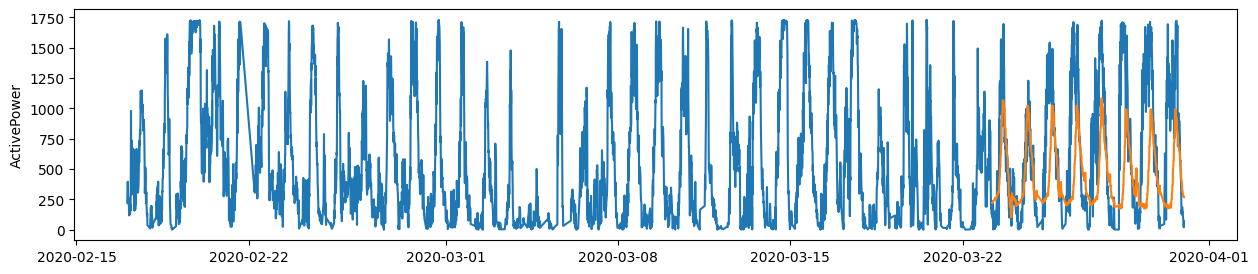

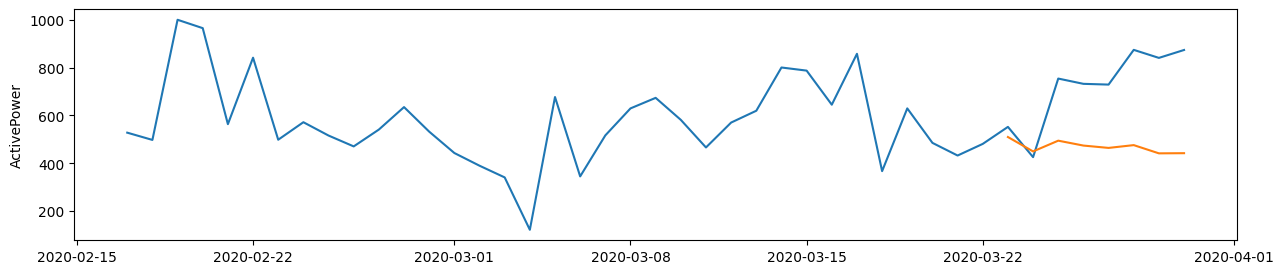

In [54]:
plt.figure(figsize=(15, 3))
sns.lineplot(data=df['ActivePower'][74000:])
sns.lineplot(data = df_final2['Predictions'])

plt.figure(figsize=(15, 3))
sns.lineplot(data = df['ActivePower'][74000:].resample('D').mean())
sns.lineplot(data = df_final2['Predictions'].resample('D').mean())

## Saving the Model

In [55]:
# import pickle
# file_name = "model1.pkl"
# pickle.dump(model, open(file_name, 'wb'))